In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display plots inline
%matplotlib inline

In [21]:
df = pd.read_csv(
    "statcast_pitch_swing_data_20240402_20241030_with_arm_angle.csv",
    parse_dates=["game_date"],          # add other date cols if present
    low_memory=False
)

# Optional: enforce expected dtypes (adjust if your columns differ)
num_cols_expect = [
    "bat_speed","swing_length","arm_angle","release_speed","effective_speed",
    "plate_x","plate_z","launch_speed","launch_angle","balls","strikes",
    "outs_when_up"
]
for c in num_cols_expect:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

cat_cols_expect = ["description","pitch_type","zone","stand","p_throws","inning_topbot"]
for c in cat_cols_expect:
    if c in df.columns:
        df[c] = df[c].astype("category")

df.head(3)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FF,2024-04-02,95.0,-2.01,5.22,"Rocchio, Brayan",677587,622491,single,hit_into_play,...,3,2,5.0,1.0,6.0,1.0,1.32,0.85,-0.85,19.4
1,CH,2024-04-02,88.5,-2.09,4.95,"Rocchio, Brayan",677587,622491,NaN,foul,...,3,2,5.0,1.0,6.0,1.0,2.82,1.40,-1.40,14.4
2,SI,2024-04-02,95.0,-2.02,5.12,"Rocchio, Brayan",677587,622491,NaN,called_strike,...,3,2,5.0,1.0,6.0,1.0,2.37,1.48,-1.48,21.9


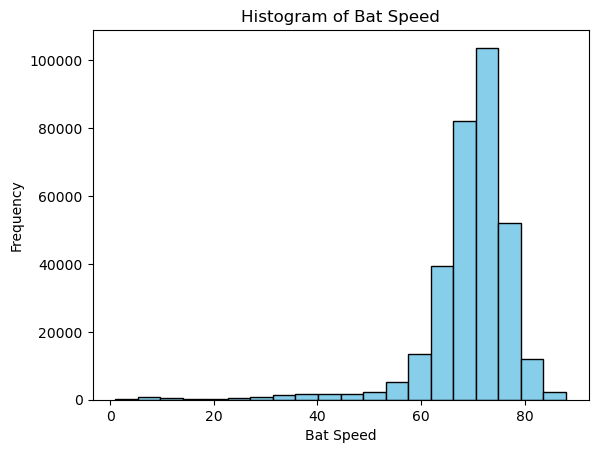

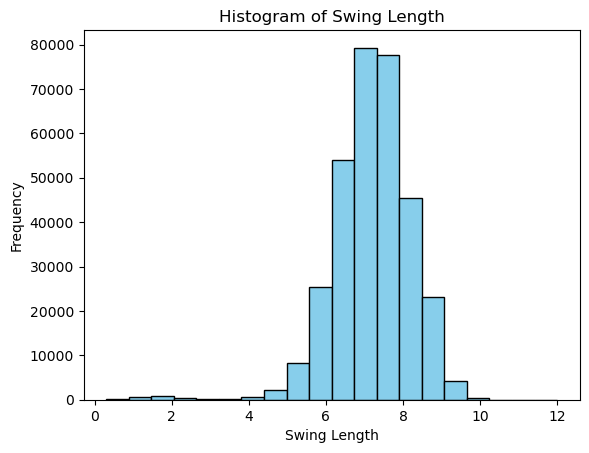

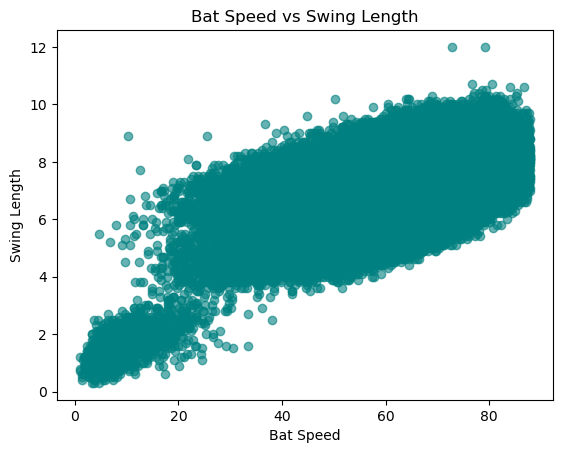

In [22]:
#Histogram of Bat Speed
plt.hist(df['bat_speed'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Bat Speed')
plt.xlabel('Bat Speed')
plt.ylabel('Frequency')
plt.show()

#Histogram of Swing Length
plt.hist(df['swing_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Swing Length')
plt.xlabel('Swing Length')
plt.ylabel('Frequency')
plt.show()

#Scatter plot comparing Swing Length and Bat Speed
plt.scatter(df['bat_speed'], df['swing_length'], alpha=0.6, color='teal')
plt.title('Bat Speed vs Swing Length')
plt.xlabel('Bat Speed')
plt.ylabel('Swing Length')
plt.show()

In [23]:
#Create and define subsets for whiffs and hard hits

#Subset of Strings
swings = df[df['description'].isin([
    'foul', 'foul_tip', 'hit_into_play', 'swinging_strike', 'swinging_strike_blocked'
])].copy()

#Whiffs
swings.loc[:, 'y_whiff'] = swings['description'].isin(['swinging_strike', 'swinging_strike_blocked']).astype(int)
whiff_counts = swings['y_whiff'].value_counts()
print(whiff_counts)
print("\nClass balance for y_whiff:")
print(f"Whiffs (misses): {whiff_counts[1]} ({whiff_counts[1]/len(swings):.1%})")
print(f"Contacts: {whiff_counts[0]} ({whiff_counts[0]/len(swings):.1%})")
#Subset of Contacts
contact = swings[
    swings['description'].isin(['foul', 'foul_tip', 'hit_into_play'])
    & swings['launch_speed'].notnull()
].copy()

#Hard hits
contact.loc[:, 'y_hardhit'] = (contact['launch_speed'] >= 95).astype(int) #speed above 95
hardhit_counts = contact['y_hardhit'].value_counts()
print(hardhit_counts)
print("\nClass balance for y_hardhit:")
print(f"Hard-hit: {hardhit_counts[1]} ({hardhit_counts[1]/len(contact):.1%})")
print(f"Not hard-hit: {hardhit_counts[0]} ({hardhit_counts[0]/len(contact):.1%})")

y_whiff
0    257403
1     77801
Name: count, dtype: int64

Class balance for y_whiff:
Whiffs (misses): 77801 (23.2%)
Contacts: 257403 (76.8%)
y_hardhit
0    179198
1     55832
Name: count, dtype: int64

Class balance for y_hardhit:
Hard-hit: 55832 (23.8%)
Not hard-hit: 179198 (76.2%)


In [28]:
num_features = [
    "bat_speed",         # how fast the bat moves
    "swing_length",      # how long the swing path is
    "arm_angle",         # hitter’s arm slot
    "release_speed",     # pitch velocity
    "effective_speed",   # perceived velocity
    "plate_x", "plate_z",# pitch location
    "balls", "strikes", "outs_when_up"
]

cat_features = [
    "pitch_type",    # e.g. fastball, slider, changeup
    "zone",          # numeric strike-zone area
    "stand",         # batter handedness
    "p_throws",      # pitcher handedness
    "inning_topbot"  # top/bottom of inning
]

df["bat_to_length_ratio"] = df["bat_speed"] / df["swing_length"]
df["bat_times_length"]    = df["bat_speed"] * df["swing_length"]

features = num_features + cat_features + ["bat_to_length_ratio","bat_times_length"]
clean_df = df[features]   # add your target column
clean_df.loc[:, 'y_whiff'] = swings['y_whiff'].values
clean_df.head()

ValueError: Length of values (335204) does not match length of index (701557)